# Code to make Figure 2
- Decadal map composites over southern Ross Sea for ice concentration and thickness
- Notebook by Alice DuVivier (NCAR)
- February 2023

In [1]:
import pandas as pd
from minisom import MiniSom, asymptotic_decay
import xarray as xr
import cftime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as cls
from itertools import product
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from datetime import timedelta
from itertools import product
import dask
import utils
import cmocean
import geopandas as gpd

## Plot decadal winter means

In [2]:
# set what variables we can plot
vars_composite_in = ['aice_d', 'hi_d']

# set paths
data_path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/DATA/data_for_composites/'
path_in = '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/'
path_out = path_in+'figures_outline/'
# set shape files info
fname= '/glade/p/cgd/ppc/duvivier/cesm2_antarctic_polynya/SOM_analysis/analysis/Ross_analysis_v4/USNIC_ANTARC_shelf_2022/USNIC_ANTARC_shelf_2022.shp' 

### USER MUST specify variable to plot

In [3]:
# USER CHOOSE WHICH VARIABLE TO PLOT: 0-1
n = 1
var_composite_in = vars_composite_in[n] 

### Continue loading the data

In [4]:
# file name for training variable only here 
fin_composite = 'antarctic_data_for_som_composites_'+var_composite_in

In [5]:
# load data
ds = xr.open_mfdataset(data_path_in+fin_composite+'.nc')

In [6]:
# explicitly load data so that it doesn't take forever later on during mean
ds = ds.load()

In [7]:
var_composite_in

'hi_d'

In [8]:
ds

<xarray.Dataset>
Dimensions:    (nj: 36, ni: 320, training_times: 232300)
Coordinates:
    time       (training_times) object 1980-07-01 00:00:00 ... 2080-09-30 00:...
    member_id  (training_times) object 'r1i1001p1f1' ... 'r9i1301p1f1'
    TLON       (nj, ni) float32 320.6 321.7 322.8 323.9 ... 317.2 318.3 319.4
    TLAT       (nj, ni) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52 -60.52
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 9 ... 26 27 28 29 30 31 32 33 34 35
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319
Dimensions without coordinates: training_times
Data variables:
    data       (nj, ni, training_times) float32 nan nan nan ... 0.07986 0.1265
Attributes:
    Author:    Alice DuVivier
    units:     m
    longname:  grid cell mean ice thickness

## Calculate the mean for all winter by decade

In [9]:
# calculate winter mean against which to do anomalies
mean_all = ds.data.mean(dim='training_times')

In [10]:
decade_names = ['1980','1990', '2000', '2010', '2020', '2030', '2040', '2050', '2060', '2070']

In [11]:
# make numpy array to fill and specify dimensions we want
decade_array = np.zeros([len(decade_names),len(mean_all.nj),len(mean_all.ni)])

for dd in decade_names:
    print('decade: '+dd+'s')
    if dd == '1980':
        d_count = 0
        yy_st = 1980
    else: 
        d_count = d_count+1
        yy_st = yy_st + 10
    # get years for this decade
    yy_ed = yy_st + 10
    yy_all = list(range(yy_st,yy_ed,1))
    # get mean for this decade
    decade_array[d_count,:,:] = ds.data.isel(training_times=ds.time.dt.year.isin([yy_all])).mean(dim='training_times')


decade: 1980s
decade: 1990s
decade: 2000s
decade: 2010s
decade: 2020s
decade: 2030s
decade: 2040s
decade: 2050s
decade: 2060s
decade: 2070s


In [12]:
print(decade_array.shape)

(10, 36, 320)


In [13]:
# convert the numpy array to a xarray for easier plotting
decade_means = xr.DataArray(decade_array,dims=('decade','nj','ni'))

In [14]:
# set coordinate arrays
decade_means['decade'] = decade_names
decade_means['nj'] = mean_all['nj'].values
decade_means['ni'] = mean_all['ni'].values

In [15]:
decade_means

<xarray.DataArray (decade: 10, nj: 36, ni: 320)>
array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [27.16223335, 25.54701042, 26.88140678, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.75258714,  0.73769802,  0.72076809, ...,  0.77840769,
          0.77410132,  0.76523793],
        [ 0.61927313,  0.60830015,  0.5957458 , ...,  0.62251765,
          0.62899172,  0.62742114],
        [ 0.47747725,  0.47013035,  0.46214983, ...,  0.45833525,
          0.47421449,  0.48067078]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [27.78128815, 26.1501503 , 27.55040741, ...,         nan,
                 nan,         nan],
...
        [ 0.22992902,  0.22428904,  0.21616817, ...,  0.23208494,
          0.23411012,  0.2336064 ],
        [ 0.13595468,  0.13113406,  0.12522708, ...,  0.13746575,
          0.14032941,  0.13964322],
        [ 0.07329193,  0.06910416,  0.06507478, ...,  0.07444259,
          0.07725701,  0.076758  ]],

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [29.98814201, 28.0469017 , 29.50631523, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.16911581,  0.16634262,  0.16042507, ...,  0.15853269,
          0.16513148,  0.16904631],
        [ 0.09324545,  0.09131924,  0.08779126, ...,  0.08602966,
          0.09118669,  0.093611  ],
        [ 0.04547113,  0.04361663,  0.04155303, ...,  0.04213266,
          0.04552518,  0.04660747]]])
Coordinates:
  * decade   (decade) <U4 '1980' '1990' '2000' '2010' ... '2050' '2060' '2070'
  * nj       (nj) int64 0 1 2 3 4 5 6 7 8 9 10 ... 26 27 28 29 30 31 32 33 34 35
  * ni       (ni) int64 0 1 2 3 4 5 6 7 8 ... 312 313 314 315 316 317 318 319

## Make plots

In [16]:
# Set plotting limits
lat_max = -72
lat_min = -80
lon_max = 200
lon_min = 160
lon_avg = 190

In [17]:
#set shape files info
shdf = gpd.read_file(fname)
# This line is important. Here we convert the projection from the shapefile one to the cartopy one 
shdf = shdf.to_crs(ccrs.SouthPolarStereo())

# Shapefile projection conversion
shdf = gpd.read_file(fname)
shdf = shdf.to_crs(ccrs.SouthPolarStereo(central_longitude=lon_avg))


In [18]:
# set some labeling things

if var_composite_in == 'aice_d':
    title = 'ice concentration' 
    units = 'sea ice concentration (%)'
    units_diff = 'change in sea ice concentration (%)'
    # levels for normal plots
    levels_in = np.arange(70,105,5)
    ticks_in = [70,80,90,100]
    cmap_in = cmocean.cm.ice
    ext_opt = 'min'
    # levels for difference plots
    levels_diff = np.arange(-25,27.5,2.5)
    ticks_diff = [-20,-15,-10,-5,0,5,10,15,20]
    cmap_diff = cmocean.cm.diff
    cmap_diff = cmap_diff.reversed()
    # labels
    l1 = 'a) '
    l2 = 'b) '
    l3 = 'c) '
    
if var_composite_in == 'hi_d':
    title = 'ice thickness' 
    units = 'sea ice thickness (cm)'
    units_diff = 'change in sea ice thickness (cm)'
    # levels for normal plots
    levels_in = np.arange(0,180,20)
    ticks_in = [0,20,40,60,80,100,120,140,160]
    cmap_in = cmocean.cm.deep
    cmap_in = cmap_in.reversed()
    ext_opt = 'max'
    # levels for difference plots
    levels_diff = np.arange(-30,35,5)
    ticks_diff = [-30,-20,-10,0,10,20,30]
    cmap_diff = cmocean.cm.diff
    cmap_diff = cmap_diff.reversed()
    # labels
    l1 = 'd) '
    l2 = 'e) '
    l3 = 'f) '
    
# set missing value color
grey_tone = 0.5

In [19]:
# bootstrap significance calculation 
# (only should be done for the far right panel; the diffs)

num_iterations = 10000  # this number should be somewhere between 1,000 to 10,000

# create empty array to use for percentile calculation
boot_diff_array = np.zeros((num_iterations, 
                      decade_means.isel(decade=0).shape[0],
                      decade_means.isel(decade=0).shape[1]))

# loop to bootstrap sample array of decades
for i in range(num_iterations):

    ar1 = np.random.choice(np.arange(0,10,1)) # pick random int
    ar2 = np.random.choice(np.arange(0,10,1)) # pick random int
    
    arr1 = 100 * decade_means.isel(decade=ar1) # pick random decade
    arr2 = 100 * decade_means.isel(decade=ar2) # pick random decade
    
    boot_diff_array[i,:,:] = arr1.values - arr2.values  # take diff of random decades

In [20]:
# convert the numpy array to a xarray for calculating
boot_diff = xr.DataArray(boot_diff_array,dims=('nboot','nj','ni'))

# set coordinate arrays
boot_diff['nj'] = mean_all['nj'].values
boot_diff['ni'] = mean_all['ni'].values

In [21]:
# using thresholds, we ask: "did this difference (2070-1980) occur by chance? or is it significant?"
# if it exceeds upper and lower bounds, it is likely that this did not occur by chance

# calculate unique value at all points over all bootstraps
max_thresh_all = boot_diff.quantile(0.975,dim='nboot')
min_thresh_all = boot_diff.quantile(0.025,dim='nboot')


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)
/glade/work/duvivier/miniconda3/envs/geo_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = super().contour(*args, **kwargs)


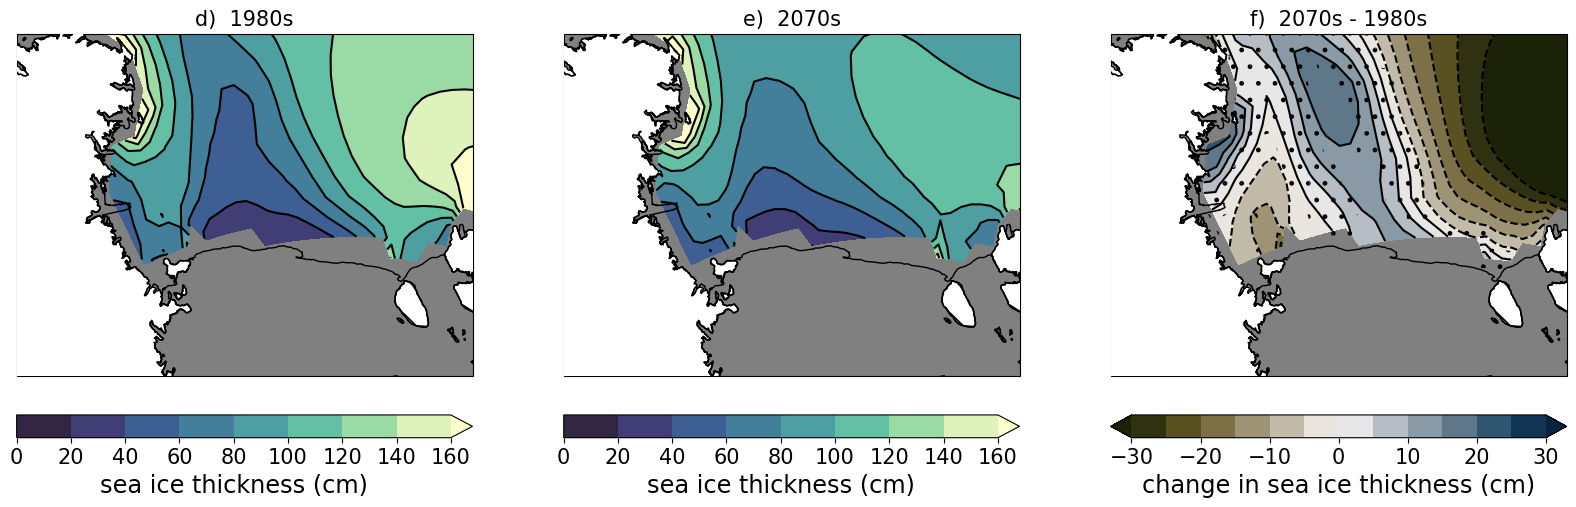

In [22]:
## 2070's difference figure
tag = '2070'
data_ctrl = 100*decade_means.sel(decade='1980')
data_in = 100*decade_means.sel(decade=tag)
data_diff = data_in - data_ctrl

# keep only data that is significantly different
sig = data_diff.where((data_diff >= max_thresh_all)|(data_diff <= min_thresh_all))
# keep only data that is NOT significancly different because we want to stipple NOT significant points
sig2 = data_diff.where((data_diff <= max_thresh_all)&(data_diff >= min_thresh_all))

# create figure
fig = plt.figure(figsize=(20,10))
fout = path_out+'fig2_'+var_composite_in

# get lats/lons for plotting
lons = ds.TLON
lats = ds.TLAT

# plot the subplots - note it's nrow x ncol x index (starting upper left)

### mean over 1980s
ax = fig.add_subplot(1,3,1, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_ctrl)
this = ax.contourf(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in,extend=ext_opt)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(units, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend='both',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(l1+' 1980s',fontsize=15)

### mean future
ax = fig.add_subplot(1,3,2, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_in)
this = ax.contourf(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   cmap = cmap_in,
                   levels=levels_in,extend=ext_opt)
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_in,label=units,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(units, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_in,extend='both',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_in)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(l2+' '+tag+'s',fontsize=15)

### diff
ax = fig.add_subplot(1,3,3, projection = ccrs.SouthPolarStereo(central_longitude=lon_avg) )
# set face colors
ax.set_facecolor([grey_tone,grey_tone,grey_tone,1])
# fix variable
lon, lat, field = utils.adjust_pop_grid(lons, lats, data_diff)
this = ax.contourf(lon,lat,
                     field,
                     transform=ccrs.PlateCarree(),
                     cmap = cmap_diff,
                     levels=levels_diff,extend='both')
cbar = plt.colorbar(this,orientation='horizontal',ticks=ticks_diff,label=units_diff,fraction=0.03,pad=0.05)
cbar.ax.tick_params(labelsize=15)
cbar.set_label(units_diff, fontsize='xx-large')
# add contours overtop
this2 = ax.contour(lon,lat,
                   field,
                   transform=ccrs.PlateCarree(),
                   colors = 'black',
                   levels=levels_diff,extend='both',linewidth=0.1)
plt.clabel(this2,colors='black',inline=1,fontsize=10,levels=levels_diff)
# add significance overtop - stippling where it is NOT significant
lon, lat, field = utils.adjust_pop_grid(lons, lats, sig2)
this3 = ax.pcolor(lon,lat,
                  field,
                  transform=ccrs.PlateCarree(),
                  hatch='.',
                  alpha= 0)
# set final plot details
ax.set_extent([lon_min,lon_max,lat_min,lat_max])
ax.add_feature(cartopy.feature.LAND, zorder=10, edgecolor='k', facecolor='w')    
#ax.gridlines(linestyle='--', linewidth=0.5, zorder=11)
# Plotting shapefile
ax.add_geometries(shdf.geometry , ccrs.SouthPolarStereo(central_longitude=lon_avg), facecolor='none', edgecolor='black',linewidth=1, zorder=10)
plt.title(l3+' '+tag+'s - 1980s',fontsize=15)

# Finalize figure and save
#fig.suptitle(title,fontsize=15, y=0.70)  
fig.subplots_adjust(hspace=0.2)
fig = plt.savefig(fout+'.png', bbox_inches='tight', dpi=200)